In [ ]:
!pip install -U -q google.generativeai

In [ ]:
# Acesso ao Google Drive
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# Importação das bibliotecas necessárias
import re
import tqdm
import numpy as np
import pandas as pd

import google.generativeai as genai
from google.colab import userdata

from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import classification_report, ConfusionMatrixDisplay

In [ ]:
# Importação da chave da API
API_KEY = userdata.get('API_KEY')
genai.configure(api_key=API_KEY)

In [ ]:
# Exibição dos modelos disponíveis
for m in genai.list_models():
    if 'embedContent' in m.supported_generation_methods:
        print(m.name)

models/embedding-001
models/text-embedding-004


In [ ]:
# Carregamento do dataset despesas liquidadas - base completa - texto formatado - balanceado
# Importa os dados
df_completo = pd.read_json('/content/drive/My Drive/projeto classificacao de lancamento/dados/despesa liquidada - base completa - texto processado - balanceado.json')
df_completo.head()

,descricao,fato_gerador,categoria,descricao_limpa,descricao_lematizada
0,Pagamento Referente Aos Serviços De Transporte...,Sim,CA,pagamento serviços transporte técnicos durante...,pagamento serviço transporte técnico durante s...
1,Pagamento Referente Aos Serviços De Transporte...,Sim,CA,pagamento serviços transporte técnicos secreta...,pagamento serviço transporte técnico Secretari...
2,Serviços De Transporte De Infraestrutura Deste...,Sim,CA,serviços transporte infraestrutura deste munic...,serviço transporte infraestrutura de este muni...
3,Pagamento Referente Aos Serviços De Transporte...,Sim,CA,pagamento serviços transporte materiais expedi...,pagamento serviço transporte material expedien...
4,Serviços De Transportes De Materiais Para Serv...,Sim,CA,serviços transportes materiais serviços infrae...,serviço transporte material serviço infraestru...


In [ ]:
# Construção de dataframe para treinamento do modelo
df = df_completo[['descricao_lematizada', 'categoria']]
df.columns = ['Text', 'Category']
df_sample = df.sample(n=8000, random_state=42)
df_train, df_test = train_test_split(df_sample, test_size=0.3, stratify=df_sample['Category'], random_state=42)

In [ ]:
# Embedding com Gemini
from tqdm.auto import tqdm
tqdm.pandas()

from google.api_core import retry

def make_embed_text_fn(model):

  @retry.Retry(timeout=300.0)
  def embed_fn(text: str) -> list[float]:
    # Set the task_type to CLASSIFICATION.
    embedding = genai.embed_content(model=model,
                                    content=text,
                                    task_type="classification")
    return embedding['embedding']

  return embed_fn

def create_embeddings(model, df):
  df['Embeddings'] = df['Text'].progress_apply(make_embed_text_fn(model))
  return df

model = 'models/embedding-001'
df_train = create_embeddings(model, df_train)
df_test = create_embeddings(model, df_test)

  0%|          | 0/5600 [00:00<?, ?it/s]

  0%|          | 0/2400 [00:00<?, ?it/s]

In [ ]:
# Divisão em treino e teste
X_train = np.array(df_train['Embeddings'].tolist())
y_train = df_train['Category']
X_test = np.array(df_test['Embeddings'].tolist())
y_test = df_test['Category']

In [ ]:
# Treinamento do modelo
sgd = SGDClassifier(random_state=42)
sgd.fit(X_train, y_train)

SGDClassifier(random_state=42)

              precision    recall  f1-score   support

          CA       0.93      0.96      0.94       134
          CI       0.98      0.99      0.99      1745
         Não       0.99      0.95      0.97       489
          SE       0.93      0.84      0.89        32

    accuracy                           0.98      2400
   macro avg       0.96      0.94      0.95      2400
weighted avg       0.98      0.98      0.98      2400



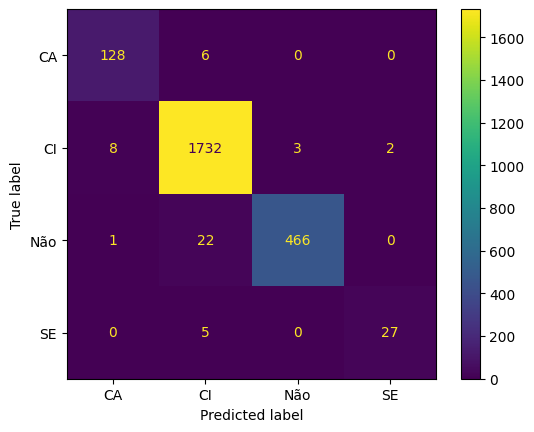

In [ ]:
# Predição e avaliação do modelo
y_pred = sgd.predict(X_test)

print(classification_report(y_test, y_pred))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)